This is one of the Objectiv [example notebooks](https://objectiv.io/docs/modeling/example-notebooks/). These notebooks can run [on your own data](https://objectiv.io/docs/modeling/get-started-in-your-notebook/), or you can instead run the [Demo](https://objectiv.io/docs/home/quickstart-guide/) to quickly try them out.

# Marketing Analytics
This example notebook shows how you can easily analyze traffic coming from Marketing campaigns, as measured via UTM tags. [See here how to get started in your notebook](https://objectiv.io/docs/modeling/get-started-in-your-notebook/).

## Setup
We first have to instantiate the model hub and an Objectiv DataFrame object.

In [1]:
from modelhub import ModelHub
from bach import DataFrame, display_sql_as_markdown
from datetime import datetime, timedelta
import pandas as pd

# instantiate the model hub and set the default time aggregation to daily
modelhub = ModelHub(time_aggregation='%Y-%m-%d')
# get a Bach DataFrame with Objectiv data within a defined timeframe
df = modelhub.get_objectiv_dataframe(start_date='2022-06-01', end_date='2022-08-31')

In [2]:
# The columns 'global_contexts' and the 'location_stack' contain most of the event specific data. These columns are json type 
# columns and we can extract data from it based on the keys of the json objects using `SeriesGlobalContexts` or 
# `SeriesLocationStack` methods to extract the data.

# add 'application', 'feature_nice_name' and 'root_location' as columns, so that we can use it for grouping etc later
df['application'] = df.global_contexts.gc.application
df['feature_nice_name'] = df.location_stack.ls.nice_name
df['root_location'] = df.location_stack.ls.get_from_context_with_type_series(type='RootLocationContext', key='id')

In [3]:
# derive a specific DataFrame with added marketing contexts
df_acquisition = df.copy()
# extract referrer and marketing contexts from the global contexts
df_acquisition['referrer'] = df_acquisition.global_contexts.gc.get_from_context_with_type_series(type='HttpContext', key='referrer')
df_acquisition['utm_source'] = df_acquisition.global_contexts.gc.get_from_context_with_type_series(type='MarketingContext', key='source')
df_acquisition['utm_medium'] = df_acquisition.global_contexts.gc.get_from_context_with_type_series(type='MarketingContext', key='medium')
df_acquisition['utm_campaign'] = df_acquisition.global_contexts.gc.get_from_context_with_type_series(type='MarketingContext', key='campaign')
df_acquisition['utm_content'] = df_acquisition.global_contexts.gc.get_from_context_with_type_series(type='MarketingContext', key='content')
df_acquisition['utm_term'] = df_acquisition.global_contexts.gc.get_from_context_with_type_series(type='MarketingContext', key='term')

In [4]:
# also define a DataFrame with only the users that came in via a marketing campaign
# TBD: does this keep all sessions that started with a marketing campaign?
df_marketing_only = df_acquisition.dropna(axis=0, how='any', subset='utm_source')

In [5]:
# define a further selection: which source to select in the below analyses.
source_selection=['twitter', 'reddit']
sources = DataFrame.from_pandas(engine=df.engine, df=pd.DataFrame({'sources': source_selection}), convert_objects=True).sources
# filter on defined list of UTM Sources
df_marketing_selection = df_marketing_only[(df_marketing_only.utm_source.isin(sources))]

#### Available dataframes:
- `df` = all + `application` + `feature_nice_name` + `root_location`.
- `df_acquisition` = `df` + referrer + all UTMs
- `df_marketing_only` = `df_acquisition`, but only sessions with non_null `utm_source`.
- `df_marketing_selection` = `df_marketing_only`, but filtered for selection, e.g. only `utm_source` in `{'reddit', 'twitter'}`.

### Reference
* [modelhub.ModelHub.get_objectiv_dataframe](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/get_objectiv_dataframe/)
* [modelhub.SeriesGlobalContexts.gc](https://objectiv.io/docs/modeling/open-model-hub/api-reference/SeriesGlobalContexts/gc/)
* [bach.DataFrame.dropna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/dropna/)
* [bach.DataFrame.from_pandas](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/from_pandas/)

# Acquisition

## Users from marketing

In [7]:
# show daily number of people coming from marketing campaigns
users_from_marketing_daily = modelhub.aggregate.unique_users(df_marketing_selection).sort_index(ascending=False)
users_from_marketing_daily.head()

time_aggregation
2022-08-09     7
2022-08-08    20
2022-08-07     6
2022-08-06     7
2022-08-05     6
Name: unique_users, dtype: int64

<AxesSubplot:title={'center':'Daily #users from marketing'}, xlabel='Day'>

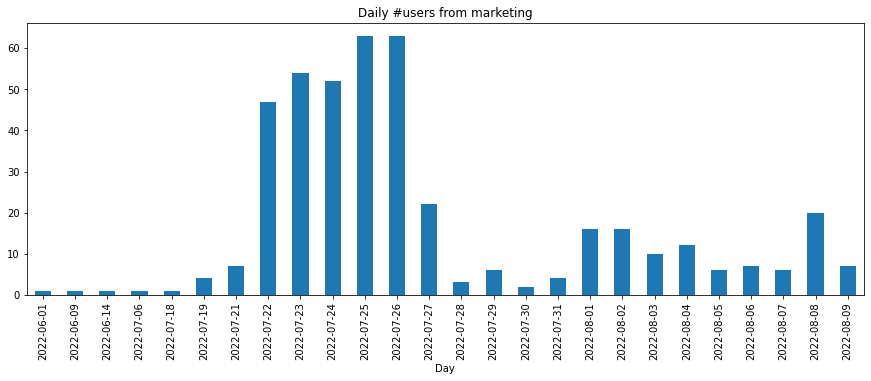

In [8]:
users_from_marketing_daily.sort_index(ascending=True).to_pandas().plot(kind='bar', figsize=[15,5], title='Daily #users from marketing', xlabel='Day')

## Users per source-medium-campaign over full timeframe

In [9]:
# split users by marketing _campaign_ (based on UTM data)
users_per_campaign = modelhub.aggregate.unique_users(df_marketing_selection, ['utm_source', 'utm_medium', 'utm_campaign'])
users_per_campaign.reset_index().dropna(axis=0, how='any', subset='utm_source').sort_values(['unique_users'], ascending=False).head(10)

,utm_source,utm_medium,utm_campaign,unique_users
0,twitter,paid,utm_test,213
1,reddit,paid,june,83
2,twitter,paid,july_conversion,65
3,reddit,paid,july_conversion,38
4,twitter,social,blog,11
5,twitter,paid,july,4
6,twitter,paidl,july,1
7,twitter,post,Oktopost-Horizontal,1


<AxesSubplot:xlabel='utm_source'>

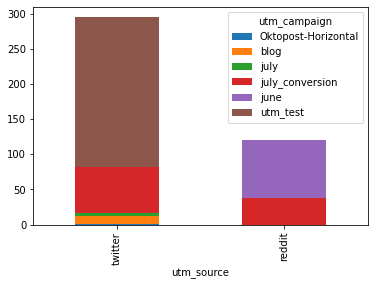

In [10]:
# Stacked graph per campaign
upc = users_per_campaign.to_frame().reset_index()[['utm_source', 'utm_campaign', 'unique_users']]
upc = upc.to_pandas().groupby(['utm_source', 'utm_campaign'])
upc_pivot = upc.sum().reset_index().pivot(index='utm_source', columns='utm_campaign')['unique_users'].reset_index().sort_values(by=['utm_source'], ascending=False)
upc_pivot.plot.bar(x='utm_source', stacked=True)

## Users from marketing _source_ per day

In [11]:
# users by marketing _source_, per day
source_users_daily = modelhub.agg.unique_users(df_marketing_selection, groupby=['utm_source', 'day'])
source_users_daily = source_users_daily.reset_index().dropna(axis=0, how='any', subset='utm_source')
source_users_daily.sort_values('utm_source', ascending=True).head(50)

,utm_source,day,unique_users
0,reddit,2022-07-18,1
1,reddit,2022-07-19,4
2,reddit,2022-07-21,1
3,reddit,2022-07-22,12
4,reddit,2022-07-23,10
5,reddit,2022-07-24,18
6,reddit,2022-07-25,19
7,reddit,2022-07-26,15
8,reddit,2022-07-27,4
9,reddit,2022-07-30,2


## Users from marketing _campaign_ per day

In [12]:
# users by marketing _campaign_ (based on UTM data), per day
users_per_campaign_daily = modelhub.aggregate.unique_users(df_marketing_selection, ['utm_source', 'utm_medium', 'utm_campaign', 'day'])
users_per_campaign_daily = users_per_campaign_daily.reset_index().dropna(axis=0, how='any', subset='utm_campaign')
users_per_campaign_daily.sort_values('utm_campaign', ascending=True).head(30)

,utm_source,utm_medium,utm_campaign,day,unique_users
0,twitter,social,blog,2022-08-09,1
1,twitter,social,blog,2022-08-01,4
2,twitter,social,blog,2022-07-28,1
3,twitter,social,blog,2022-07-21,1
4,twitter,social,blog,2022-07-06,1
5,twitter,social,blog,2022-06-14,1
6,twitter,social,blog,2022-06-09,1
7,twitter,social,blog,2022-06-01,1
8,twitter,paidl,july,2022-07-21,1
9,twitter,paid,july,2022-07-22,1


## Referrers overall

In [13]:
# users by referrer in full timeframe (overall, including coming from marketing campaigns)
referrer_users = modelhub.agg.unique_users(df_acquisition, groupby=['referrer']).sort_values(ascending=False).to_frame()
referrer_users.head(20)

,unique_users
referrer,
,1068
https://objectiv.io/,151
https://www.google.com/,147
https://www.reddit.com/,105
https://t.co/,59
https://www.linkedin.com/,46
https://github.com/,36
https://github.com/objectiv/objectiv-analytics,34
https://stackshare.io/,17


array([<AxesSubplot:ylabel='unique_users'>], dtype=object)

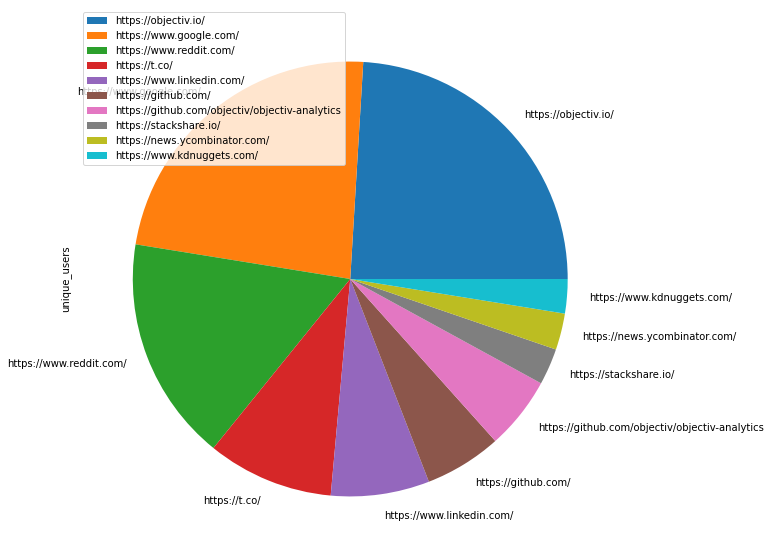

In [14]:
# plot referrers in pie chart, but remove first index with empty referrers
referrer_users.reset_index()[1:].set_index('referrer').to_pandas(limit=10).plot(kind='pie', subplots=True, figsize=[20,10])

## Recent referrers (past 7 days)

In [15]:
# recent referrers (seen in past 7 days)
recent_timeframe = datetime.today() - timedelta(days=7)
df_acquisition_recent = df_acquisition[df_acquisition.day > recent_timeframe]
referrer_users_recent = modelhub.agg.unique_users(df_acquisition_recent, groupby=['referrer']).sort_values(ascending=False).to_frame()
referrer_users_recent.head(40)

,unique_users
referrer,
,1


### Reference
* [bach.Series.sort_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/sort_index/)
* [bach.Series.to_pandas](https://objectiv.io/docs/modeling/bach/api-reference/Series/to_pandas/)
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [bach.Series.reset_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/reset_index/)
* [bach.Series.group_by](https://objectiv.io/docs/modeling/bach/api-reference/Series/group_by/)
* [bach.DataFrame.dropna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/dropna/)
* [bach.DataFrame.to_pandas](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/to_pandas/)
* [bach.Series.to_frame](https://objectiv.io/docs/modeling/bach/api-reference/Series/to_frame/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

# Conversion
See conversion overall and from marketing. Conversion in this example is defined as clicking any link on the website or docs to our GitHub repo.

In [16]:
# define the conversion event; in this example: clicking any link leading to our GitHub repo.
# create a column that extracts all location stacks that lead to our GitHub repo
df_acquisition['github_press'] = df_acquisition.location_stack.json[{'id': 'browse-on-github', '_type': 'LinkContext'}:]
df_acquisition.loc[df_acquisition.location_stack.json[{'id': 'github', '_type': 'LinkContext'}:]!=[],'github_press'] = df_acquisition.location_stack
# set all events in this location stack to be used as conversion events
modelhub.add_conversion_event(location_stack=df_acquisition.github_press,
                              event_type='PressEvent',
                              name='github_press')
df_acquisition['is_conversion_event'] = modelhub.map.is_conversion_event(df_acquisition, 'github_press')

In [17]:
# define the conversion event also for the dataframe with only users coming from marketing
df_marketing_only['github_press'] = df_marketing_only.location_stack.json[{'id': 'browse-on-github', '_type': 'LinkContext'}:]
df_marketing_only.loc[df_marketing_only.location_stack.json[{'id': 'github', '_type': 'LinkContext'}:]!=[],'github_press'] = df_marketing_only.location_stack
# set all events in this location stack to be used as conversion events
modelhub.add_conversion_event(location_stack=df_marketing_only.github_press,
                              event_type='PressEvent',
                              name='github_press')
df_marketing_only['is_conversion_event'] = modelhub.map.is_conversion_event(df_marketing_only, 'github_press')

In [18]:
# define the conversion event also for the dataframe with only users coming from marketing, filtered by a UTM param selection
df_marketing_selection['github_press'] = df_marketing_selection.location_stack.json[{'id': 'browse-on-github', '_type': 'LinkContext'}:]
df_marketing_selection.loc[df_marketing_selection.location_stack.json[{'id': 'github', '_type': 'LinkContext'}:]!=[],'github_press'] = df_marketing_selection.location_stack
# set all events in this location stack to be used as conversion events
modelhub.add_conversion_event(location_stack=df_marketing_selection.github_press,
                              event_type='PressEvent',
                              name='github_press')
df_marketing_selection['is_conversion_event'] = modelhub.map.is_conversion_event(df_marketing_selection, 'github_press')

### Reference
* [bach.series.series_json.JsonAccessor](https://objectiv.io/docs/modeling/bach/api-reference/Series/Json/json/)
* [modelhub.ModelHub.add_conversion_event](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/add_conversion_event/)
* [modelhub.Map.is_conversion_event](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/is_conversion_event/)

## Daily conversions from marketing

In [ ]:
# calculate daily conversions from marketing (based on UTM data)
conversions_from_marketing = df_marketing_selection[df_marketing_selection.is_conversion_event].dropna(axis=0, how='any', subset='utm_source')
conversions_from_marketing_daily = modelhub.aggregate.unique_users(conversions_from_marketing).sort_index(ascending=False)
conversions_from_marketing_daily.head()

<AxesSubplot:title={'center':'Daily #conversions from marketing'}, xlabel='Day'>

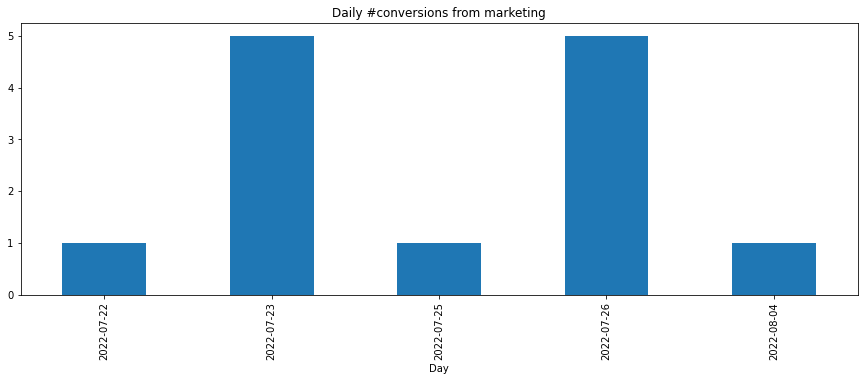

In [10]:
conversions_from_marketing_daily.sort_index(ascending=True).to_pandas().plot(kind='bar', figsize=[15,5], title='Daily #conversions from marketing', xlabel='Day')

## Daily conversion rate from marketing

In [11]:
# calculate daily conversion rate from marketing campaigns overall
# divide conversions from campaigns by total daily number of people coming from campaigns 
conversion_rate_from_marketing = (conversions_from_marketing_daily / users_from_marketing_daily) * 100
conversion_rate_from_marketing.sort_index(ascending=False).fillna(0.0).head(10)

time_aggregation
2022-08-09    0.000000
2022-08-08    0.000000
2022-08-07    0.000000
2022-08-06    0.000000
2022-08-05    0.000000
2022-08-04    8.333333
2022-08-03    0.000000
2022-08-02    0.000000
2022-08-01    0.000000
2022-07-31    0.000000
Name: unique_users, dtype: float64

<AxesSubplot:title={'center':'Daily conversion rate from marketing'}, xlabel='Day'>

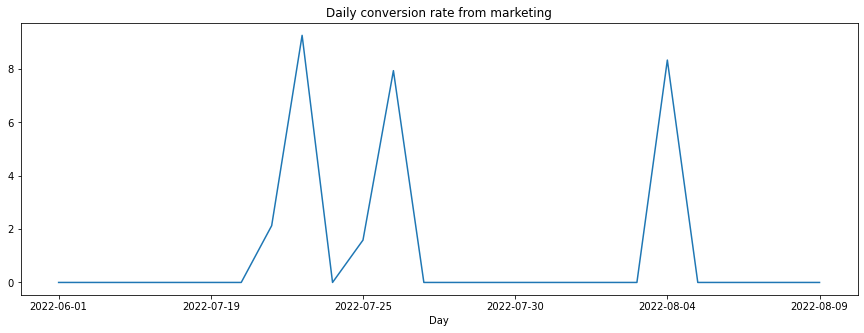

In [12]:
conversion_rate_from_marketing.fillna(0.0).sort_index(ascending=True).to_pandas().plot(kind='line', figsize=[15,5], title='Daily conversion rate from marketing', xlabel='Day')

## Daily conversions overall

In [13]:
# calculate daily conversions overall (including from marketing campaigns)
conversions_overall = modelhub.aggregate.unique_users(df_acquisition[df_acquisition.is_conversion_event])
conversions_overall.sort_index(ascending=False).head()

time_aggregation
2022-08-09    2
2022-08-08    2
2022-08-07    1
2022-08-06    2
2022-08-05    1
Name: unique_users, dtype: int64

<AxesSubplot:title={'center':'Daily #conversions overall'}, xlabel='Day'>

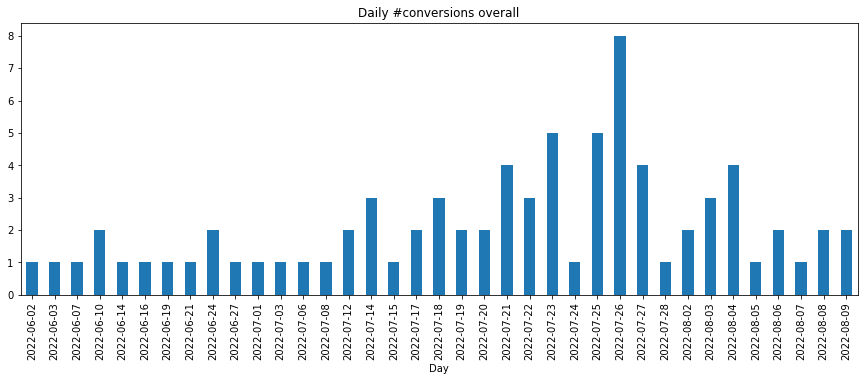

In [14]:
# plot daily conversions overall (including from marketing campaigns)
# TODO: don't understand why I can't use https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/plot/
conversions_overall.to_pandas().plot(kind='bar', figsize=[15,5], title='Daily #conversions overall', xlabel='Day')

### Daily conversion rate overall

In [15]:
# calculate daily conversion rate overall (including from marketing campaigns)
daily_users = modelhub.aggregate.unique_users(df_acquisition).sort_index(ascending=False)
conversion_rate_overall = (conversions_overall / daily_users) * 100
conversion_rate_overall.sort_index(ascending=False).head(10)

time_aggregation
2022-08-22          NaN
2022-08-09     8.000000
2022-08-08     4.166667
2022-08-07     5.263158
2022-08-06    12.500000
2022-08-05     3.030303
2022-08-04     6.250000
2022-08-03     7.894737
2022-08-02     4.545455
2022-08-01          NaN
Name: unique_users, dtype: float64

<AxesSubplot:title={'center':'Daily conversion rate overall'}, xlabel='Day'>

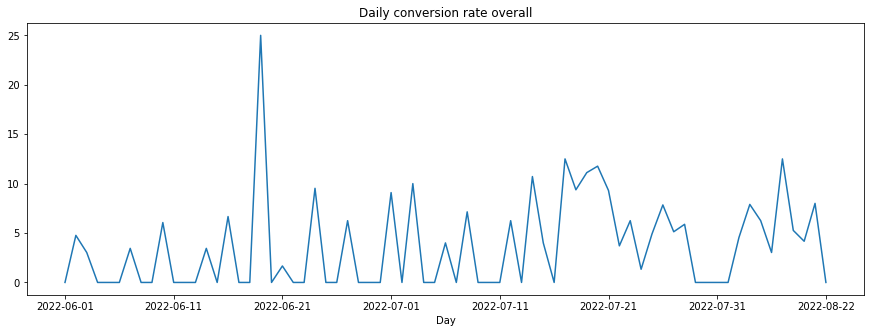

In [16]:
conversion_rate_overall.sort_index(ascending=True).fillna(0.0).to_pandas().plot(kind='line', figsize=[15,5], title='Daily conversion rate overall', xlabel='Day')

### Reference
* [modelhub.Map.is_conversion_event](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/is_conversion_event/)
* [bach.DataFrame.dropna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/dropna/)
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [bach.Series.sort_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/sort_index/)
* [bach.DataFrame.to_pandas](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/to_pandas/)
* [bach.DataFrame.fillna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/fillna/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

## Conversion split by source & campaign

### Conversions per marketing _source_ over full timeframe

In [17]:
# calculate conversions per marketing _source_ over the full timeframe (based on UTM data)
campaign_conversions_source_timeframe = modelhub.aggregate.unique_users(df_marketing_selection[df_marketing_selection.is_conversion_event], ['utm_source'])
campaign_conversions_source_timeframe.reset_index().dropna(axis=0, how='any', subset='utm_source').sort_values(['unique_users'], ascending=False).head()

,utm_source,unique_users
0,twitter,9
1,reddit,3


### Conversions per marketing _source_ daily

In [18]:
# split daily conversions by marketing _source_ (based on UTM data)
campaign_conversions_source_daily = modelhub.aggregate.unique_users(df_marketing_selection[df_marketing_selection.is_conversion_event], ['day','utm_source'])
campaign_conversions_source_daily.reset_index().dropna(axis=0, how='any', subset='utm_source').set_index('day').sort_index(ascending=False).head(10)

,utm_source,unique_users
day,,
2022-08-04,twitter,1
2022-07-26,reddit,1
2022-07-26,twitter,4
2022-07-25,twitter,1
2022-07-23,twitter,3
2022-07-23,reddit,2
2022-07-22,twitter,1


### Conversions per marketing _campaign_ over full timeframe

In [19]:
# split conversions by marketing _campaign_ (based on UTM data)
campaign_conversions_campaign = modelhub.aggregate.unique_users(df_marketing_selection[df_marketing_selection.is_conversion_event], ['utm_source', 'utm_medium', 'utm_campaign'])
campaign_conversions_campaign.reset_index().dropna(axis=0, how='any', subset='utm_source').sort_values(['utm_source', 'unique_users'], ascending=False).head()

,utm_source,utm_medium,utm_campaign,unique_users
0,twitter,paid,utm_test,9
1,twitter,paid,july_conversion,1
2,reddit,paid,june,3


### Reference
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [modelhub.Map.is_conversion_event](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/is_conversion_event/)
* [bach.DataFrame.dropna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/dropna/)
* [bach.DataFrame.sort_values](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/sort_values/)
* [bach.Series.sort_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/sort_index/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

# Avg. duration

## Avg. duration per ad source

In [20]:
# avg duration for users that come from an ad campaign in the full timeframe
duration_per_source = modelhub.aggregate.session_duration(df_marketing_selection, groupby=['utm_source']).to_frame()
duration_per_source.sort_values(['utm_source'], ascending=False).head(10)

,session_duration
utm_source,
twitter,0 days 00:02:21.409402
reddit,0 days 00:02:05.284562


In [21]:
# TODO: Plat a graph of session duration per source; error: TypeError: value should be a 'Timedelta', 'NaT', or array of those. Got 'int' instead.
# duration_per_source.to_pandas().plot(kind='bar', figsize=[15,5], title='Session duration per source', xlabel='Source')

## Vs. avg. duration by all users

In [22]:
# vs time spent by all users
modelhub.aggregate.session_duration(df_acquisition, groupby=None).to_frame().head()

,session_duration
0,0 days 00:03:37.613029


## Avg. duration per converted user

In [ ]:
# duration before conversion - per source & user
# label sessions with a conversion
df_marketing_selection['converted_users'] = modelhub.map.conversions_counter(df_marketing_selection, name='github_press') >= 1
# label hits where at that point in time, there are 0 conversions in the session
df_marketing_selection['zero_conversions_at_moment'] = modelhub.map.conversions_in_time(df_marketing_selection, 'github_press') == 0
# filter on above created labels to find the users who converted for the very first time
converted_users = df_marketing_selection[(df_marketing_selection.converted_users & df_marketing_selection.zero_conversions_at_moment)]

modelhub.aggregate.session_duration(converted_users, groupby=['day', 'utm_source', 'user_id']).to_frame().sort_values('day', ascending=False).head(20)

## Avg. duration before first conversion
Avg. duration for users that converted for the very first time (not including sessions where users have converted later as well).

In [ ]:
# avg duration before conversion - overall
modelhub.aggregate.session_duration(converted_users, groupby=None).to_frame().head()

## Avg. duration before first conversion per _source_
Avg. duration per campaign _source_ for users who converted for the very first time (not including sessions where they've converted after that).

In [ ]:
# avg duration before conversion - per source
modelhub.aggregate.session_duration(converted_users, groupby=['utm_source']).to_frame().head()

## Avg. duration with bounces filtered out

In [ ]:
# create dataframe for users without zero duration (aka bounces)
users_from_ads_duration = modelhub.aggregate.session_duration(df_marketing_selection, groupby=['utm_source','user_id'], exclude_bounces=False).to_frame()
# TODO: filtering session_duration '0 days 00:00:00' provides different results, but shouldn't this already be handled by the `exclude_bounces` parameter?
df_marketing_no_bounces = users_from_ads_duration[users_from_ads_duration['session_duration'] != '0 days 00:00:00']

In [ ]:
# avg duration for non-bounced users that come from an ad campaign in the full timeframe
df_marketing_no_bounces.reset_index().groupby(['utm_source'])['session_duration'].mean().to_frame().sort_values(['utm_source'], ascending=False).head(30)

In [ ]:
# TODO: Plat a graph of session duration per source; error: TypeError: value should be a 'Timedelta', 'NaT', or array of those. Got 'int' instead.
# df_marketing_no_bounces.to_pandas().plot(kind='bar', figsize=[15,5], title='Session duration per source', xlabel='Source')

## Avg. daily duration per campaign _source_

In [ ]:
# calculate time spent per campaign source, daily
duration_per_source_daily = modelhub.agg.session_duration(df_marketing_selection, groupby=['utm_source', 'day']).to_frame()
# calculate the number of users per campaign source, daily
source_users_daily = modelhub.agg.unique_users(df_acquisition, groupby=['utm_source', 'day'])
source_users_daily = source_users_daily.reset_index().dropna(axis=0, how='any', subset='utm_source')
# add them together
source_duration_users_daily = duration_per_source_daily.merge(source_users_daily, how='left', on=['utm_source', 'day']);
# also add #conversions
converted_users = campaign_conversions_source_daily.to_frame().rename(columns={"unique_users": "converted_users"})
source_duration_users_daily = source_duration_users_daily.merge(converted_users, how='left', on=['utm_source', 'day'])

source_duration_users_daily = source_duration_users_daily.sort_values(['utm_source', 'day'], ascending=False)
source_duration_users_daily.head(50)

### Reference
* [modelhub.Aggregate.session_duration](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/session_duration/)
* [bach.DataFrame.sort_values](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/sort_values/)
* [modelhub.Map.conversions_counter](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/conversions_counter/)
* [modelhub.Map.conversions_in_time](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/conversions_in_time/)
* [bach.Series.to_frame](https://objectiv.io/docs/modeling/bach/api-reference/Series/to_frame/)
* [bach.Series.reset_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/reset_index/)
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [bach.DataFrame.dropna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/dropna/)
* [bach.DataFrame.merge](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/merge/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

# Deep-dive into user behavior from marketing

## Predict User Behavior from campaigns
Predict which campaign is most likely to convert users to go to our GitHub repo.

In [ ]:
# only look at PressEvents and count the root locations
predict_features = df_marketing_selection[(df_marketing_selection.event_type=='PressEvent')].groupby(['user_id', 'utm_source', 'utm_medium', 'utm_campaign']).root_location.value_counts().to_frame()

# add number of clicks on any of the GitHub links to the `features` DataFrame, instead of the number of hits on a root_location
predict_converted_users = df_marketing_selection[df_marketing_selection['is_conversion_event'] == True]
predict_converted_users_marketing = predict_converted_users[(predict_converted_users.event_type=='PressEvent')].groupby(['user_id', 'utm_source', 'utm_medium', 'utm_campaign']).event_type.value_counts().to_frame()
predict_converted_users_marketing = predict_converted_users_marketing.reset_index().rename(columns={'event_type': 'root_location'}).set_index(['user_id', 'utm_source', 'utm_medium', 'utm_campaign', 'root_location'])
predict_features = predict_features.append(predict_converted_users_marketing)

# unstack the series, to create a DataFrame with the number of clicks per root location as columns
predict_features_unstacked = predict_features.unstack(fill_value=0)
predict_features_unstacked.head(40)

y_column = 'PressEvent__value_counts'
y = predict_features_unstacked[y_column] > 0
X = predict_features_unstacked.drop(columns=[y_column])

lr = modelhub.get_logistic_regression(fit_intercept=False)
lr.fit(X, y)

predict_features_unstacked['predicted_values'] = lr.predict_proba(X)
predict_features_unstacked['predicted_labels'] = lr.predict(X)

results = predict_features_unstacked[['predicted_values', 'predicted_labels']].reset_index().dropna(axis=0, how='any', subset='utm_source')

results_aggregated = results.groupby(['utm_source', 'utm_medium', 'utm_campaign', 'predicted_labels']).agg({'predicted_values':'mean'}).reset_index()

results_aggregated.sort_values(['predicted_values_mean'], ascending=False).head(60)

### Reference
* [bach.DataFrame.groupby](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/groupby/)
* [bach.Series.value_counts](https://objectiv.io/docs/modeling/bach/api-reference/Series/value_counts/)
* [bach.Series.to_frame](https://objectiv.io/docs/modeling/bach/api-reference/Series/to_frame/)
* [bach.Series.reset_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/reset_index/)
* [bach.DataFrame.rename](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/rename/)
* [bach.Series.unstack](https://objectiv.io/docs/modeling/bach/api-reference/Series/unstack/)
* [modelhub.ModelHub.get_logistic_regression](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/get_logistic_regression/)
* [modelhub.LogisticRegression.fit](https://objectiv.io/docs/modeling/open-model-hub/models/machine-learning/LogisticRegression/fit/)
* [modelhub.LogisticRegression.predict_proba](https://objectiv.io/docs/modeling/open-model-hub/models/machine-learning/LogisticRegression/predict_proba/)
* [modelhub.LogisticRegression.predict](https://objectiv.io/docs/modeling/open-model-hub/models/machine-learning/LogisticRegression/predict/)
* [bach.Series.reset_index](https://objectiv.io/docs/modeling/bach/api-reference/Series/reset_index/)
* [bach.DataFrame.dropna](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/dropna/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

## Top used product features for users from marketing campaigns

In [ ]:
# top used product features for users coming from marketing campaigns
top_product_features_from_marketing = modelhub.aggregate.top_product_features(df_marketing_selection)
top_product_features_from_marketing.head(20)

### Top used product features for users from marketing campaigns, before they convert

In [ ]:
# top used product features for users coming from marketing campaigns, before they convert
top_features_before_conversion_from_marketing = modelhub.agg.top_product_features_before_conversion(df_marketing_selection, name='github_press')
top_features_before_conversion_from_marketing.head(20)

In [ ]:
# calculate the percentage of converted users per feature: (converted users per feature) / (total users converted)
total_converted_users = df_marketing_selection[df_marketing_selection['is_conversion_event']]['user_id'].unique().count().value
top_conversion_locations = modelhub.agg.unique_users(df_marketing_selection[df_marketing_selection['is_conversion_event']], groupby='feature_nice_name')
top_conversion_locations = (top_conversion_locations / total_converted_users) * 100
# show the results, with .to_frame() for nicer formatting
top_conversion_locations = top_conversion_locations.to_frame().rename(columns={'unique_users': 'converted_users_percentage'})
top_conversion_locations.sort_values(by='converted_users_percentage', ascending=False).head()

### Reference
* [modelhub.Aggregate.top_product_features](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/top_product_features/)
* [modelhub.Aggregate.top_product_features_before_conversion](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/top_product_features_before_conversion/)
* [bach.Series.unique](https://objectiv.io/docs/modeling/bach/api-reference/Series/unique/)
* [bach.Series.count](https://objectiv.io/docs/modeling/bach/api-reference/Series/count/)
* [bach.Series.to_frame](https://objectiv.io/docs/modeling/bach/api-reference/Series/to_frame/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

## Funnel Discovery: flows for _all_ users from marketing campaigns

In [ ]:
# select which event type to use for further analysis - PressEvents to focus on what users directly interact with
df_funnel_from_marketing = df_marketing_selection[df_marketing_selection['event_type'] == 'PressEvent']
# instantiate the FunnelDiscovery model from the open model hub
funnel = modelhub.get_funnel_discovery()
# set the maximum n steps
max_steps = 4

In [ ]:
# for every user starting their session, find all maximum n consecutive steps they took
df_steps = funnel.get_navigation_paths(df_funnel_from_marketing, steps=max_steps, by='user_id')
df_steps.head()

In [ ]:
# calculate the most frequent consecutive steps that all users took after starting their session, based on the location stack
df_steps.value_counts().to_frame().head(20)

In [ ]:
funnel.plot_sankey_diagram(df_steps, n_top_examples=50)

## Funnel Discovery: flows for _converted_ users from marketing

In [ ]:
# add which step resulted in conversion to the dataframe, with the `add_conversion_step_column` param
# filter down to all sequences that have actually converted with the `only_converted_paths` param
df_steps_till_conversion = funnel.get_navigation_paths(df_funnel_from_marketing, steps=max_steps, by='user_id', add_conversion_step_column=True, only_converted_paths=True)
df_steps_till_conversion.head(5)

In [ ]:
# plot the Sankey diagram using the top examples via the `n_top_examples` param
condition_convert_on_step = df_steps_till_conversion['_first_conversion_step_number'] == 2
funnel.plot_sankey_diagram(df_steps_till_conversion[condition_convert_on_step], n_top_examples=15)

## Funnel Discovery: drop-off for users from marketing

In [ ]:
# select only non-converted users
df_funnel_non_converted = df_marketing_selection[~df_marketing_selection['is_conversion_event']]
funnel_converted_users = df_marketing_selection[df_marketing_selection['is_conversion_event']]['user_id']
# select the events of these non converted users
df_funnel_non_converted = df_funnel_non_converted[~df_funnel_non_converted['user_id'].isin(funnel_converted_users)]
# get the last used feature in the location_stack before dropping off
drop_loc = df_funnel_non_converted.sort_values('moment').groupby('user_id')['feature_nice_name'].to_json_array().json[-1].materialize()
total_count = drop_loc.count().value
# show the last used features by non-converted users, sorted by their usage share compared to all features
drop_loc_percent = (drop_loc.value_counts() / total_count) * 100
drop_loc_percent = drop_loc_percent.to_frame().rename(columns={'value_counts': 'drop_percentage'})
drop_loc_percent.sort_values(by='drop_percentage', ascending=False).head(10)

### Reference
* [modelhub.ModelHub.get_funnel_discovery](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/get_funnel_discovery/)
* [modelhub.FunnelDiscovery.get_navigation_paths](https://objectiv.io/docs/modeling/open-model-hub/models/funnels/FunnelDiscovery/get_navigation_paths/)
* [bach.Series.to_frame](https://objectiv.io/docs/modeling/bach/api-reference/Series/to_frame/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)
* [modelhub.FunnelDiscovery.plot_sankey_diagram](https://objectiv.io/docs/modeling/open-model-hub/models/funnels/FunnelDiscovery/plot_sankey_diagram/)
* [bach.DataFrame.rename](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/rename/)
* [bach.DataFrame.sort_values](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/sort_values/)